In [28]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from matplotlib.ticker import PercentFormatter

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

RANDOM_SEED = 17

# Данные

In [3]:
df = pd.read_csv('df_cleared.csv')

In [4]:
df.sample(8)

,status,propertyType,street,baths,fireplace,city,sqft,state,stories,PrivatePool,target,has_adress,built_year,was_remodeled,remodel_year,house_age,last_remodeled,heating,cooling,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school,sqft_type,beds_cleared_2,beds_type
23840,FOR SALE,SINGLE,AVENUE,3.0,0,PANAMA CITY,2000,FL,0,0.0,130000,1,1950,0,0,72,-1,NO_DATA,NO_DATA,NONE,3,0.38,0.490000,1.0,4.0,2.666667,2,5,3
201778,FOR SALE,SINGLE,PLACE,5.0,1,TAMPA,4203,FL,2,1.0,849000,1,1985,1,2001,37,20,AIR,CENTRAL,OTHER,3,1.20,1.823333,5.0,9.0,7.333333,3,4,2
53498,FOR SALE,SINGLE,AVENUE,2.0,0,WACO,1328,TX,1,0.0,149500,1,1950,1,1982,72,39,OTHER,CENTRAL,OTHER,3,0.44,1.370000,2.0,3.0,2.333333,2,3,2
24378,ACTIVE,SINGLE,DRIVE,2.0,0,PALM COAST,1600,FL,1,0.0,223000,1,1989,0,0,33,-1,ELECTRIC,CENTRAL,NONE,8,0.40,2.325000,4.0,6.0,5.200000,2,3,2
70582,CONTRACT,SINGLE,DRIVE,2.0,1,NASHVILLE,1336,TN,1,0.0,229900,1,1987,0,0,35,-1,OTHER,OTHER,OTHER,8,0.90,1.937500,1.0,3.0,1.800000,2,3,2
182126,ACTIVE,NO DATA,ROAD,2.0,0,TAMPA,1762,FL,1,0.0,269900,1,1992,1,2004,30,17,CENTRAL,CENTRAL,NONE,3,1.10,1.466667,6.0,9.0,7.333333,2,3,2
25165,FOR SALE,TOWNHOUSE,STREET,2.0,0,DETROIT,1647,MI,2,0.0,774900,1,1917,0,0,105,-1,AIR,CENTRAL,OTHER,13,0.27,4.050000,2.0,6.0,3.461538,2,2,1
173503,FOR SALE,TOWNHOUSE,BOULEVARD,4.0,0,MIAMI,2163,FL,0,0.0,990000,1,1997,0,0,25,-1,AIR,CENTRAL,OTHER,5,0.67,8.848000,2.0,10.0,6.000000,2,3,2


## Категориальные признаки

### dummies

Некоторые категориальные признаки с маленьким количеством классов разобьем на dummies

Разобьем те, у которых категорий меньше 6

In [5]:
cols_dummies = []

for col in df.columns:
    if df[col].nunique() < 6:
        cols_dummies.append(col)

In [6]:
cols_dummies

['fireplace',
 'stories',
 'PrivatePool',
 'has_adress',
 'was_remodeled',
 'cooling',
 'sqft_type',
 'beds_type']

In [7]:
df = pd.get_dummies(df, 
                    columns=cols_dummies, drop_first=True)

In [8]:
df

,status,propertyType,street,baths,city,sqft,state,target,built_year,remodel_year,house_age,last_remodeled,heating,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school,beds_cleared_2,fireplace_1,fireplace_2,stories_1,stories_2,stories_3,PrivatePool_1.0,has_adress_1,was_remodeled_1,cooling_NONE,cooling_NO_DATA,cooling_OTHER,sqft_type_1,sqft_type_2,sqft_type_3,beds_type_2,beds_type_3,beds_type_4
0,ACTIVE,SINGLE,OTHER,4.0,SOUTHERN PINES,2900,NC,418000,2019,0,3,-1,AIR,NONE,8,2.70,5.537500,4.0,7.0,5.200000,4,1,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0
1,FOR SALE,SINGLE,AVENUE,3.0,SPOKANE VALLEY,1947,WA,310000,2019,0,3,-1,NO_DATA,NONE,3,1.01,1.326667,4.0,4.0,4.000000,3,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0
2,FOR SALE,TOWNHOUSE,STREET,2.0,PHILADELPHIA,897,PA,209000,1920,0,102,-1,AIR,NONE,0,99.00,99.000000,0.0,0.0,0.000000,2,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0
3,ACTIVE,OTHER,COURT,2.0,POINCIANA,1507,FL,181500,2006,2006,16,15,AIR,NONE,4,0.80,3.825000,1.0,3.0,2.333333,3,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0
4,ACTIVE,NO DATA,DRIVE,2.0,MEMPHIS,1920,TN,68000,1976,0,46,-1,NO_DATA,NONE,3,0.40,1.100000,2.0,4.0,2.666667,3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319038,NO_DATA,SINGLE,STREET,2.0,HOUSTON,1841,TX,252990,2019,0,3,-1,NO_DATA,TWO,3,0.30,1.766667,5.0,7.0,6.000000,4,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0
319039,FOR SALE,TOWNHOUSE,STREET,3.0,WASHINGTON,1417,DC,799000,2010,0,12,-1,AIR,ONE,2,0.10,0.250000,3.0,3.0,3.000000,2,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
319040,FOR SALE,TOWNHOUSE,DRIVE,3.0,CHICAGO,2000,IL,674999,1924,0,98,-1,OTHER,NONE,3,0.40,4.143333,1.0,7.0,4.333333,3,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0
319041,FOR SALE,SINGLE,BOULEVARD,3.0,JAMAICA,1152,NY,528000,1950,1950,72,71,OTHER,TWO,2,0.48,0.605000,4.0,5.0,4.500000,3,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,0,0


### label encoder

In [9]:
col_label = ['status', 'propertyType', 'street', 'city', 'sqft', 'state', 'heating', 'parking']

In [10]:
label_encoder = LabelEncoder()
for column in col_label:
    df[column] = label_encoder.fit_transform(df[column])


In [11]:
df.sample(5)

,status,propertyType,street,baths,city,sqft,state,target,built_year,remodel_year,house_age,last_remodeled,heating,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school,beds_cleared_2,fireplace_1,fireplace_2,stories_1,stories_2,stories_3,PrivatePool_1.0,has_adress_1,was_remodeled_1,cooling_NONE,cooling_NO_DATA,cooling_OTHER,sqft_type_1,sqft_type_2,sqft_type_3,beds_type_2,beds_type_3,beds_type_4
160955,5,13,12,2.0,1236,1677,29,250000,2016,0,6,-1,5,1,1,0.89,0.890000,1.0,1.0,1.000000,3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
243265,8,22,4,4.0,734,3123,32,295000,1984,1984,38,37,6,0,3,1.10,2.100000,6.0,7.0,6.333333,4,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0
125299,8,22,12,2.0,1000,1533,6,298321,1960,1960,62,61,5,2,2,1.20,12.900000,2.0,10.0,6.000000,4,0,0,1,0,0,0,1,1,0,1,0,0,1,0,1,0,0
76153,0,13,11,2.0,273,1677,20,269000,1985,0,37,-1,5,1,6,2.40,3.400000,3.0,7.0,4.666667,3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
152434,5,24,1,2.0,110,1160,6,449000,1978,1986,44,35,5,4,3,1.54,2.226667,3.0,6.0,4.000000,2,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0


## Корреляция признаков

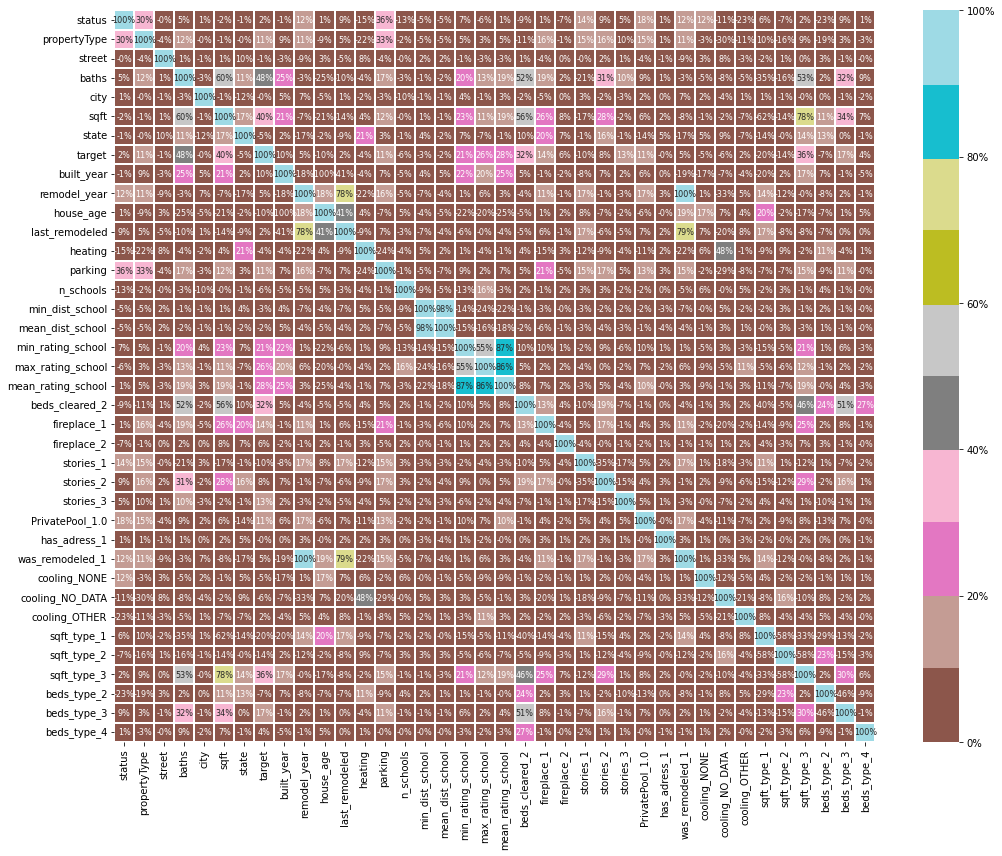

In [12]:
#plt.figure(figsize=(15,12))
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(
        #dataframe.corr().abs(),
        df.corr(),
        annot=True, 
        fmt=".0%", linewidths=0.1, cmap="tab20", annot_kws={'size':8}, #Set1 tab20
        center=0, vmin=0, vmax=1)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
plt.tight_layout()
plt.show()

Корреляция с целевой переменной

In [13]:
X = df.drop(columns='target')
y = df['target']

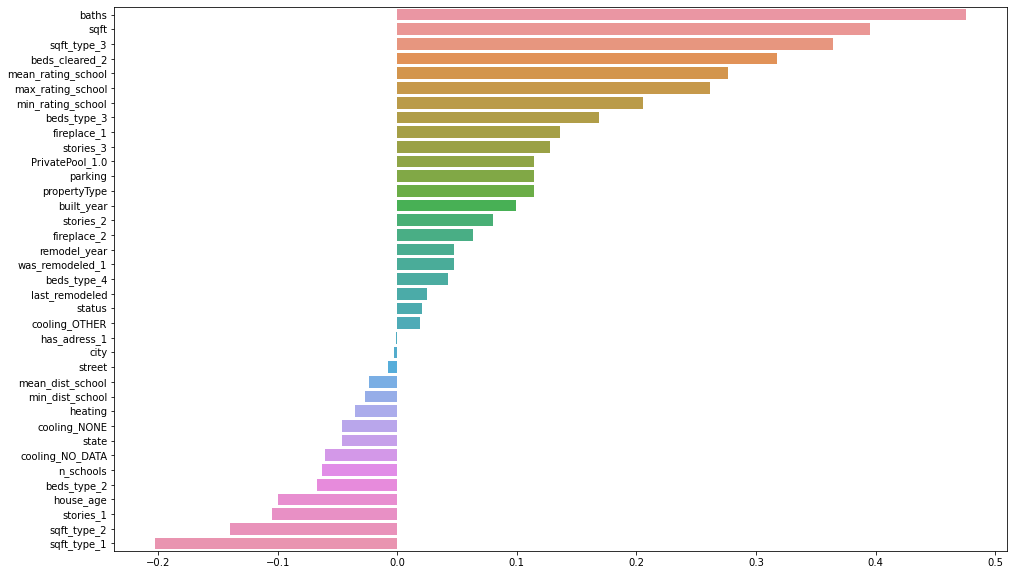

In [14]:
correlations = X.corrwith(y).sort_values(ascending=False)
plt.figure(figsize=(16, 10))
plot = sns.barplot(y=correlations.index, x=correlations)

Пока оставим все признаки. Если что - потом откинем некоторые.

## Scaling

Тк мы будем обучать много различных моделей, включая даже самую базовую линейную регрессию, лучше будет пронормировать признаки.

In [15]:
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [16]:
X

,status,propertyType,street,baths,city,sqft,state,built_year,remodel_year,house_age,last_remodeled,heating,parking,n_schools,min_dist_school,mean_dist_school,min_rating_school,max_rating_school,mean_rating_school,beds_cleared_2,fireplace_1,fireplace_2,stories_1,stories_2,stories_3,PrivatePool_1.0,has_adress_1,was_remodeled_1,cooling_NONE,cooling_NO_DATA,cooling_OTHER,sqft_type_1,sqft_type_2,sqft_type_3,beds_type_2,beds_type_3,beds_type_4
0,0.000000,0.88,0.615385,0.8,0.840796,0.461205,0.540541,0.990950,0.000000,0.009050,0.000000,0.000000,0.166667,0.123077,0.001698,0.003468,0.4,0.7,0.520000,0.375,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.416667,0.88,0.000000,0.6,0.845771,0.295782,0.972973,0.990950,0.000000,0.009050,0.000000,0.833333,0.166667,0.046154,0.000635,0.000821,0.4,0.4,0.400000,0.250,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.416667,0.96,0.923077,0.4,0.683250,0.113522,0.783784,0.542986,0.000000,0.457014,0.000000,0.000000,0.166667,0.000000,0.062249,0.062220,0.0,0.0,0.000000,0.125,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.76,0.230769,0.4,0.694306,0.219406,0.162162,0.932127,0.992578,0.067873,0.072072,0.000000,0.166667,0.061538,0.000503,0.002392,0.1,0.3,0.233333,0.250,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.000000,0.68,0.307692,0.4,0.546711,0.291095,0.837838,0.796380,0.000000,0.203620,0.000000,0.833333,0.166667,0.046154,0.000252,0.000679,0.2,0.4,0.266667,0.250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319038,0.666667,0.88,0.923077,0.4,0.405749,0.277382,0.864865,0.990950,0.000000,0.009050,0.000000,0.833333,1.000000,0.046154,0.000189,0.001098,0.5,0.7,0.600000,0.375,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
319039,0.416667,0.96,0.923077,0.6,0.946932,0.203784,0.108108,0.950226,0.000000,0.049774,0.000000,0.000000,0.333333,0.030769,0.000063,0.000145,0.3,0.3,0.300000,0.125,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
319040,0.416667,0.96,0.307692,0.6,0.158098,0.304982,0.270270,0.561086,0.000000,0.438914,0.000000,1.000000,0.166667,0.046154,0.000252,0.002592,0.1,0.7,0.433333,0.250,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
319041,0.416667,0.88,0.076923,0.6,0.430625,0.157785,0.621622,0.678733,0.964869,0.321267,0.324324,1.000000,1.000000,0.030769,0.000302,0.000368,0.4,0.5,0.450000,0.250,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Train test split

- train - 70%
- test - 20%
- val - 10%

In [17]:
X_train, X_for_test, y_train, y_for_test = train_test_split(X, y, test_size=0.3, 
                                                            shuffle=True, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_for_test, y_for_test, test_size=0.66, 
                                                shuffle=True, random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(223330, 37) (223330,) (32542, 37) (32542,) (63171, 37) (63171,)


# Модели

## Выбранные метрики

- MAE - средний модуль отклонения.
- MAPE - средний процент отклонения.
- R2 Коэффициент детерминации - это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости. Коэффициент можно рассматривать как универсальную меру зависимости одной случайной величины от множества других.

**Интерпретация R2:**
- Коэффициент детерминации принимает значения от 0 до 1.
- Для приемлемых моделей коэффициент должен быть не меньше 50%.
- Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими.
- Коэффициент может быть отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше.


In [18]:
def metrics_print(y_test, y_pred):
    print(f"MAE: {mean_absolute_error(y_test, y_pred).round(2)}$")
    print(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred).round(2)}%")
    print(f"R2: {r2_score(y_test, y_pred).round(2)}%")

## Baseline

Предсказание примитивного алгоритма - среднее значение

<AxesSubplot:>

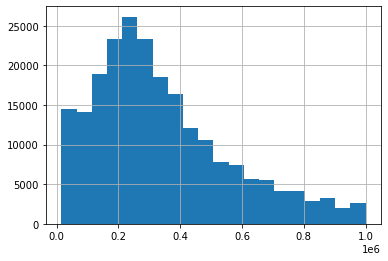

In [19]:
y_train.hist(bins=20)

In [20]:
y_train.mean()

342456.2925760086

In [21]:
mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape) * mean_train
metrics_print(y_test, baseline_predictions)

MAE: 176432.46$
MAPE: 1.2%
R2: -0.0%


## LinearRegression

In [22]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
metrics_print(y_test, y_pred)

MAE: 187555.26$
MAPE: 0.95%
R2: -0.2%


Как видим модель получилась абсолютно неадекватная. Даже хуже, чем базовый алгоритм

## Random Forest

In [23]:
rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
metrics_print(y_test, y_pred)

MAE: 67006.56$
MAPE: 0.3%
R2: 0.79%


Отличный результат! R2 79% это уже очень хорошо! МАЕ при этом улучшилось почти в три раза.

## Light Gradient Boosting

In [26]:
lgbm = LGBMRegressor(n_jobs=-1, random_state=RANDOM_SEED)
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
metrics_print(y_test, y_pred)

MAE: 86015.8$
MAPE: 0.4%
R2: 0.72%


Модель тоже показала отличный результат, но немного хуже, чем случайный лес.

## Extreme Gradient Boosting

In [27]:
xgbm = XGBRegressor(n_jobs=1, random_state=RANDOM_SEED)
xgbm.fit(X_train, y_train)

y_pred = xgbm.predict(X_test)
metrics_print(y_test, y_pred)

MAE: 76241.7$
MAPE: 0.34%
R2: 0.77%


Модель показала результат, очень схожий на случайный лес, но все же лес показал себя лучше.

Применять глубинное обучение к этой задачи нет особого смысла, тк это классическая задача регрессии. DL все таки актуален при работе с текстом, картинками, звуком, а тут отлично справляются классические модели.

Использование DL здесь не оправдано как минимум с точки зрения ресурсов.

Будем настраивать случайный лес, тк дефолтная модель показала наилучшиый результат.

## Подбор гиперпараметров к Random Forest

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = [int(x) for x in np.linspace(start = 10, stop = 37, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

Одна модель на всех ядрах обучается 25 секунд.

Сначала я думала просто запустить поиск наилучшей модели по сетке, но тогда сетка будет обучаться более 68 часов!

Попробуем подобрать самые важные параметры вручную.

### max_features

In [34]:
max_features = [int(x) for x in np.linspace(start = 10, stop = 37, num = 10)]

In [35]:
results = {}

for m_feat in max_features:
    rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, max_features=m_feat)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f'Для {m_feat} фичей: ')
    metrics_print(y_test, y_pred)
    print('-------------------------')

Для 10 фичей: 
MAE: 68602.97$
MAPE: 0.31%
R2: 0.79%
-------------------------
Для 13 фичей: 
MAE: 67875.97$
MAPE: 0.3%
R2: 0.79%
-------------------------
Для 16 фичей: 
MAE: 67125.02$
MAPE: 0.3%
R2: 0.8%
-------------------------
Для 19 фичей: 
MAE: 66829.32$
MAPE: 0.3%
R2: 0.8%
-------------------------
Для 22 фичей: 
MAE: 66540.15$
MAPE: 0.3%
R2: 0.8%
-------------------------
Для 25 фичей: 
MAE: 66376.73$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 28 фичей: 
MAE: 66273.35$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 31 фичей: 
MAE: 66240.64$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 34 фичей: 
MAE: 66472.1$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 37 фичей: 
MAE: 67006.56$
MAPE: 0.3%
R2: 0.79%
-------------------------


Как видим, самое оптимальное кол-во фичей 22-31

### n_estimators

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 8)]

In [39]:
results = {}

for n_est in n_estimators:
    rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, n_estimators=n_est)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f'Для {n_est} деревьев: ')
    metrics_print(y_test, y_pred)
    print('-------------------------')

Для 100 деревьев: 
MAE: 67006.56$
MAPE: 0.3%
R2: 0.79%
-------------------------
Для 228 деревьев: 
MAE: 66738.32$
MAPE: 0.3%
R2: 0.79%
-------------------------
Для 357 деревьев: 
MAE: 66661.74$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 485 деревьев: 
MAE: 66627.94$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 614 деревьев: 
MAE: 66599.02$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 742 деревьев: 
MAE: 66581.55$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 871 деревьев: 
MAE: 66581.58$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 1000 деревьев: 
MAE: 66564.56$
MAPE: 0.29%
R2: 0.8%
-------------------------


Отлично. Видим, что после 700 деревьев МАЕ перестала уменьшаться.

### max_depth

In [40]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 7)]

In [42]:
results = {}

for m_depth in max_depth:
    rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, n_estimators=700, max_depth=m_depth)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f'Для {m_depth} максимальной глубины: ')
    metrics_print(y_test, y_pred)
    print('-------------------------')

Для 10 максимальной глубины: 
MAE: 100126.28$
MAPE: 0.48%
R2: 0.63%
-------------------------
Для 25 максимальной глубины: 
MAE: 68030.16$
MAPE: 0.3%
R2: 0.79%
-------------------------
Для 40 максимальной глубины: 
MAE: 66607.4$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 55 максимальной глубины: 
MAE: 66589.87$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 70 максимальной глубины: 
MAE: 66586.53$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 85 максимальной глубины: 
MAE: 66586.53$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 100 максимальной глубины: 
MAE: 66586.53$
MAPE: 0.29%
R2: 0.8%
-------------------------


После глубины 70 МАЕ перестала уменьшаться. 

### Еще раз кол-во фичей

In [43]:
max_features = [20,23,26,29,32]

In [44]:
results = {}

for m_feat in max_features:
    rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, max_features=m_feat,
                               n_estimators=700, max_depth=70)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    print(f'Для {m_feat} фичей: ')
    metrics_print(y_test, y_pred)
    print('-------------------------')

Для 20 фичей: 
MAE: 66311.71$
MAPE: 0.3%
R2: 0.8%
-------------------------
Для 23 фичей: 
MAE: 66084.63$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 26 фичей: 
MAE: 65921.99$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 29 фичей: 
MAE: 65880.05$
MAPE: 0.29%
R2: 0.8%
-------------------------
Для 32 фичей: 
MAE: 65945.99$
MAPE: 0.29%
R2: 0.8%
-------------------------


Отлично. Мы пробили порог МАЕ в 66к. 

Итог:

Мы подобрали гиперпараметры случайного леса. Лучшая модель оказалась со следующими параметрами:
- n_estimators = 700
- max_depth = 70
- max_features = 29

# Заключение

В результате EDA было создано много новых признаков, а также почищены выбросы, пропуски и плохие значения. Как итог мы получили хороший датасет, на котором модели показывают хорошие результаты.

Основной метрикой MAE и MAPE, так как первая показывает средний модуль отклонения, а вторая средний процент отклонения от цены.

Во время разработки модели машинного обучения было опробовано несколько методов и выбран лучший, к которому в итоге дополнительно подобрали гиперпараметры.

Модели:

**Примитивная модель**
- MAE: 176432.46$
- MAPE: 1.2%
- R2: -0.0%

**Линейная регрессия**
- MAE: 187555.26$
- MAPE: 0.95%
- R2: -0.2%

Линейная регрессия оказалась даже хуже, чем "предсказание среднего"

**Случайный лес**
- MAE: 67006.56$
- MAPE: 0.3%
- R2: 0.79%

Метрики стали в разы лучше у нелинейной модели.

**Light Gradient Boosting**
- MAE: 86015.8$
- MAPE: 0.4%
- R2: 0.72%

Метрики значительно хуже, чем у случайного леса.

**Extreme Gradient Boosting**
- MAE: 76241.7$
- MAPE: 0.34%
- R2: 0.77%

Результат чуть лучше, чем у LGBM, но все равно сильно хуже, чем у RF.

**Как итог, решили настроить RF.**

После перебора гиперпараметров были выявлены слудующие значения параметров.

- n_estimators = 700
- max_depth = 70
- max_features = 29

И метрики улучшились больше, чем на 2000$:

- MAE: 65880.05$
- MAPE: 0.29%
- R2: 0.8%

Итоговая модель практически в 3 раза точней (по метрике МАЕ), чем примитивное предсказание. Я считаю, что это отличный результат.